In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd ./drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW1

/content/drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW1


In [ ]:
!pip install numpy
!pip install pandas

In [ ]:
import numpy as np
import csv
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import chardet
import pandas as pd

def get_csv_header(file_name) :
    date_list = []

    with open(f"./data/{file_name}","r",newline='', encoding = "big5") as file :
        csv_reader = csv.reader(file)
        next(csv_reader)
        for index,line in enumerate(csv_reader):
            if line[2] not in date_list:
                date_list.append(line[2])

    # np array

    return date_list


def slice_one_day_train(file_name) : # N * 24
    date_list = []

    with open(f"./data/{file_name}","r",newline='', encoding='big5') as file :
        csv_reader = csv.reader(file)
        next(csv_reader)
        for index,line in enumerate(csv_reader):
            line = ["0" if element == "NR" else element for element in line]
            date_list.append(line[3:])

    # np array
    rd_array = np.array(date_list)
    rd_array = rd_array.astype(float)
    return rd_array

def slice_one_day_test(file_name) : # N * 24
    date_list = []

    with open(f"./data/{file_name}","r",newline='', encoding='big5') as file :
        csv_reader = csv.reader(file)
        for index,line in enumerate(csv_reader):
            line = ["0" if element == "NR" else element for element in line]
            date_list.append(line[2:])

    # np array
    rd_array = np.array(date_list)
    rd_array = rd_array.astype(float)
    return rd_array


In [ ]:
# read from csv

pointer_list = get_csv_header("train.csv")

train_raw_data = slice_one_day_train("train.csv")
train_raw_data = train_raw_data.reshape(train_raw_data.size//(20*18*24),20,18,24)
train_raw_data = train_raw_data.transpose(0,2,1,3).reshape(12,18, 20 * 24)

test_raw_data = slice_one_day_test("test.csv")
test_data = test_raw_data.reshape(test_raw_data.size//(18*9),18,9)


print(train_raw_data.shape)
print(test_raw_data.shape)

(12, 18, 480)
(4320, 9)


In [ ]:
# slice to 9 hour

train_data = []
train_data_label = []

for i in range(train_raw_data.shape[0]):
    for k in range(9,train_raw_data.shape[2]):
        train_data.append(train_raw_data[i,:,k-9:k])
        train_data_label.append(train_raw_data[i,9,k])

train_data = np.array(train_data)
train_data_label = np.array(train_data_label)

print(train_data_label[:40])



[30. 41. 44. 33. 37. 36. 45. 42. 49. 45. 44. 41. 30. 24. 13. 21. 23. 30.
 30. 22. 18. 13. 13. 11. 22. 25. 34. 38. 50. 53. 43. 43. 45. 46. 32. 16.
 19. 22. 26. 19.]


In [ ]:
# scalize

train_data_mean = train_data.transpose(1,2,0).mean(axis=2).reshape(1,18,9)
train_data_std = train_data.transpose(1,2,0).std(axis=2).reshape(1,18,9)
train_data = (train_data - train_data_mean)/train_data_std

original_train_data_label_mean = train_data_label.mean()
original_train_data_label_std = train_data_label.std()

train_data_label = (train_data_label - train_data_label.mean()) / train_data_label.std()

test_data_mean = test_data.transpose(1,2,0).mean(axis=2).reshape(1,18,9)
test_data_std = test_data.transpose(1,2,0).std(axis=2).reshape(1,18,9)
test_data = (test_data - test_data_mean)/test_data_std

In [ ]:
# training function

def model(x,w):
  return x @ w

def loss(y_hat,y):
  return np.sum((y_hat - y) ** 2)

def loss_dim(y_hat,y):
  return (y_hat - y) ** 2

def GD(y_hat,y,x, learning_rate, w):
  gradient = x.T @ (y_hat - y) / x.shape[0] * -2 ## 如果是 y_hat - y : 會是 -2; 如果是 y - y_hat : 會是 2
  w = w - learning_rate * gradient
  return w

def ADA(y_hat,y,x, learning_rate, w, history_gradient):
  gradient = x.T @ (y_hat - y) / x.shape[0] * -2
  w = w - learning_rate * gradient

  history_gradient = history_gradient + gradient ** 2
  learning_rate = learning_rate / np.sqrt(history_gradient)

  return w, history_gradient, learning_rate

def SGD(y_hat,y,x, learning_rate, w, sample_size):
  s_index_list = np.random.choice(list(range(x.shape[0])),sample_size,replace=False)
  this_x = x[s_index_list,:]
  this_y = y[s_index_list]
  this_y_hat = y_hat[s_index_list]
  gradient = this_x.T @ (this_y_hat - this_y) / this_x.shape[0] * -2
  w = w - learning_rate * gradient
  return w


In [ ]:
# choose input (pointer,hour,power)

# para_list = []

# for i in range(18):
#   for j in range(9):
#     para_list.append([i,j,1])

para_list = [
    [2,2,1],
    [2,3,1],
    [2,4,1],
    [2,5,1],
    [2,6,1],
    [2,7,1],
    [2,8,1],
    [4,8,1],
    [7,7,1],
    [7,8,1],
    [8,1,1],
    [8,2,1],
    [8,3,1],
    [8,4,1],
    [8,5,1],
    [8,6,1],
    [8,7,1],
    [8,8,1],
    [9,3,1],
    [9,4,1],
    [9,5,1],
    [9,6,1],
    [9,7,1],
    [9,8,1],
    [12,7,1]
]


# para_list = [
#     [2,2,1],
#     [2,3,1],
#     [2,4,1],
#     [2,5,1],
#     [2,6,1],
#     [2,7,1],
#     [2,8,1],
#     [4,8,5],
#     [7,7,5],
#     [7,8,5],
#     [8,1,5],
#     [8,2,5],
#     [8,3,5],
#     [8,4,5],
#     [8,5,3],
#     [8,6,3],
#     [8,7,1],
#     [8,8,1],
#     [9,3,5],
#     [9,4,5],
#     [9,5,3],
#     [9,6,3],
#     [9,7,1],
#     [9,8,1],
#     [12,7,5]
# ]

# para_list = [
#     [2,2,5],
#     [2,3,5],
#     [2,4,5],
#     [2,5,5],
#     [2,6,5],
#     [2,7,5],
#     [2,8,5],
#     [4,8,5],
#     [7,7,5],
#     [7,8,5],
#     [8,1,5],
#     [8,2,5],
#     [8,3,5],
#     [8,4,5],
#     [8,5,5],
#     [8,6,5],
#     [8,7,5],
#     [8,8,5],
#     [9,3,5],
#     [9,4,5],
#     [9,5,5],
#     [9,6,5],
#     [9,7,5],
#     [9,8,5],
#     [12,7,5]
# ]



def find_max_power(para_list):
  np_para_list = np.array(para_list)
  return np.max(np_para_list[:,2])

def selection_list(para_list,max_power):
  np_para_list = np.array(para_list)
  index_list = []
  time_list = []
  power_list = []


  for power in range(1,max_power+1):
    mask_array = np_para_list >= power
    mask_array = mask_array[:,2]
    index_list.append(np_para_list[mask_array,0])
    time_list.append(np_para_list[mask_array,1])
    power_list.extend([power for i in np_para_list[mask_array,0]])

  np_power_list = np.array(power_list)

  return index_list,time_list,np_power_list


In [ ]:
# feature selection


index_list,time_list,np_power_list = selection_list(para_list,find_max_power(para_list))



x = train_data[:5650,index_list[0],time_list[0]]
train_data_label = train_data_label[:5650]
test_x = test_data[:,index_list[0],time_list[0]]



for index,i in enumerate(range(1,len(index_list))):
  power = index + 2
  temp_x = train_data[:5650,index_list[i],time_list[i]] ** power
  x = np.concatenate((x,temp_x),axis=1)

b = np.ones(x.shape[0])[:,None]
x = np.concatenate((x,b),axis=1)
test_x = np.concatenate((test_x,np.ones(test_x.shape[0])[:,None]),axis=1)

feature_size = x.shape[1]

print(feature_size)




26


In [ ]:
#learning setting

learning_rate = np.array([0.0001 for i in range(feature_size)])
history_learning_rate = np.array([0 for i in range(feature_size)])

fold_n = 5
epoch = 10000

sample = 100

In [ ]:
#好像不是傳旨ㄟ


In [ ]:
# training



train_loss_list_total = []
val_loss_list_total = []


for index in range(fold_n) :
  batch_list = list(range(fold_n))
  batch_list.remove(index)

  np.random.seed(42)
  w = np.random.rand(x.shape[1])

  train_x = x.reshape(fold_n,-1,feature_size)[batch_list,:,:]
  train_x = train_x.reshape(-1,feature_size)
  train_y = train_data_label.reshape(fold_n,-1)[batch_list,:]
  train_y = train_y.reshape(-1)

  val_x = x.reshape(fold_n,-1,feature_size)[index,:,:]
  val_x = val_x.reshape(-1,feature_size)
  val_y = train_data_label.reshape(fold_n,-1)[index,:]
  val_y = val_y.reshape(-1)


  train_loss_list = []
  val_loss_list = []

  # print(train_x.shape)

  learning_rate = np.array([0.01 for i in range(feature_size)])
  history_gradient = np.array([0 for i in range(feature_size)])



  for index in tqdm(range(epoch)):

    train_hypo_y = model(train_x,w)
    train_loss = loss(train_y,train_hypo_y) / train_y.size
    train_loss_list.append(train_loss)

    val_hypo_y = model(val_x,w)
    val_loss = loss(val_y,val_hypo_y) / val_y.size
    val_loss_list.append(val_loss)

    w = GD(train_y,train_hypo_y,train_x, learning_rate, w)
    # w, history_gradient, learning_rate = ADA(train_y,train_hypo_y,train_x, learning_rate, w, history_gradient)

    # w = SGD(train_y,train_hypo_y,train_x, learning_rate, w, sample)

    # print(f"ephoch #{str(index).ljust(5)} loss={round(train_loss,6)}")





  train_loss_list_total.append(train_loss_list)
  val_loss_list_total.append(val_loss_list)







100%|██████████| 10000/10000 [00:04<00:00, 2321.18it/s]


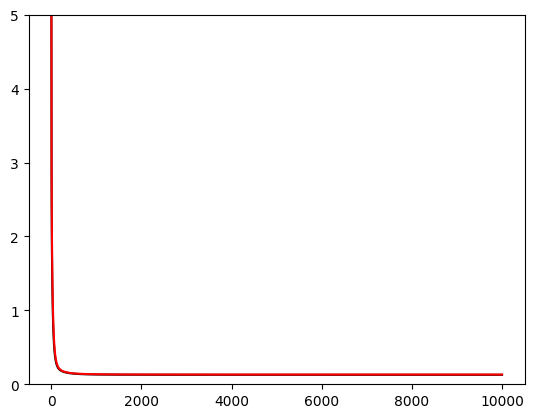

In [ ]:
# drawing

x_axis = np.arange(epoch)

train_loss_axis = np.array(train_loss_list_total)
val_loss_axis = np.array(val_loss_list_total)

train_loss_axis = train_loss_axis.mean(axis=0)
val_loss_axis = val_loss_axis.mean(axis=0)

plt.ylim([0,5])

plt.plot(x_axis,train_loss_axis,"k")
plt.plot(x_axis,val_loss_axis,"r")


plt.show()

In [ ]:
# total training

train_loss = 100
last_loss = 1000000

np.random.seed(42)
w = np.random.rand(x.shape[1])



train_loss_list = []
test_loss = []

learning_rate = np.array([0.01 for i in range(feature_size)])
history_gradient = np.array([0 for i in range(feature_size)])


epoch = 1

while last_loss - train_loss >= 10 ** -6:

  if epoch >= 2:
    last_loss = train_loss

  y = model(x,w)


  train_loss = loss(train_data_label,y) / train_data_label.size
  train_loss_list.append(train_loss)



  w = GD(train_data_label,y,x, learning_rate, w)

  # w, history_gradient, learning_rate = ADA(train_data_label,y,x, learning_rate, w, history_gradient)
  # w = SGD(train_data_label,y,x, learning_rate, w, 2000)

  print(f"ephoch #{str(epoch).ljust(5)} loss={round(train_loss,6)}")


  # history_learning_rate = history_learning_rate + learning_rate ** 2
  # learning_rate = learning_rate / np.sqrt(history_learning_rate)

  epoch+=1





ephoch #1     loss=34.663765
ephoch #2     loss=22.108016
ephoch #3     loss=14.528158
ephoch #4     loss=9.930441
ephoch #5     loss=7.121424
ephoch #6     loss=5.386602
ephoch #7     loss=4.298102
ephoch #8     loss=3.599599
ephoch #9     loss=3.13745
ephoch #10    loss=2.819478
ephoch #11    loss=2.590311
ephoch #12    loss=2.41662
ephoch #13    loss=2.278282
ephoch #14    loss=2.163095
ephoch #15    loss=2.063609
ephoch #16    loss=1.975231
ephoch #17    loss=1.89509
ephoch #18    loss=1.821354
ephoch #19    loss=1.752825
ephoch #20    loss=1.68869
ephoch #21    loss=1.628376
ephoch #22    loss=1.571463
ephoch #23    loss=1.517623
ephoch #24    loss=1.466594
ephoch #25    loss=1.418157
ephoch #26    loss=1.372125
ephoch #27    loss=1.328331
ephoch #28    loss=1.286629
ephoch #29    loss=1.246884
ephoch #30    loss=1.208977
ephoch #31    loss=1.172795
ephoch #32    loss=1.138235
ephoch #33    loss=1.105205
ephoch #34    loss=1.073616
ephoch #35    loss=1.043387
ephoch #36    loss=1.

In [ ]:
print(train_y[:10])
print(train_hypo_y[:10])
print(val_y[:10])
print(val_hypo_y[:10])

[0.51922102 1.18134123 1.36191947 0.69979926 0.94057025 0.8803775
 1.42211222 1.24153398 1.66288321 1.42211222]
[-0.15441487  0.73490528  1.37465449  1.20701965  0.42150218  0.79387014
  1.08480958  1.19526258  1.20358265  1.41968094]
[-0.44386293 -0.50405568  0.15806453  0.03767904 -0.02251371 -0.20309195
 -0.20309195  0.39883552  0.27845003  0.57941376]
[-0.98716156 -0.42903413 -0.3658517  -0.02603822  0.08651509 -0.36390972
 -0.19233319 -0.19553122  0.44751692  0.39893796]


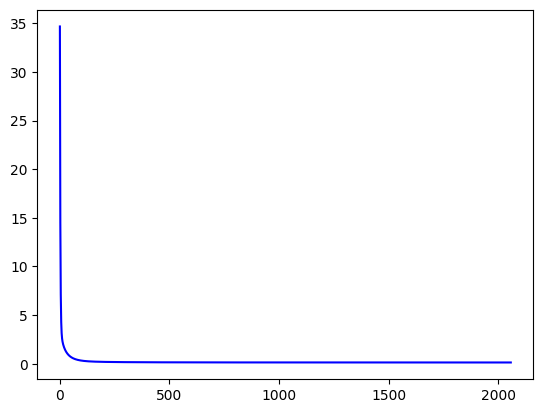

In [ ]:
# drawing

x_axis = np.arange(len(train_loss_list))
plt.plot(x_axis,train_loss_list,"b")

plt.show()

In [ ]:
# testing

test_y = model(test_x,w)
test_y = test_y * original_train_data_label_std + original_train_data_label_mean
print(list(np.round(test_y,2)))

with open("./submission.csv","w",newline='') as file:
  csv_writer = csv.writer(file)

  csv_writer.writerow(["id","value"])

  for index,value in enumerate(test_y):
    csv_writer.writerow([f"id_{index}",f"{value}"])


[20.01, 50.97, 16.4, 20.95, 5.87, 25.53, 30.63, 11.24, 37.24, 25.34, 27.15, 44.82, 26.77, 30.2, 21.99, 7.85, 40.28, 16.53, 12.01, 13.49, 11.89, 21.45, 30.23, 5.86, 45.56, 35.71, 19.65, 5.49, 24.38, 27.8, 12.94, 7.79, 12.82, 4.33, 11.85, 31.39, 14.56, 20.57, 10.2, 47.14, 36.42, 19.75, 39.69, 14.24, 34.01, 38.25, 45.97, 31.5, 41.2, 30.22, 21.86, 17.0, 31.25, 18.42, 29.83, 31.24, 18.91, 15.08, 29.5, 25.66, 8.78, 20.42, 23.09, 40.78, 36.34, 19.34, 30.93, 41.21, 20.75, 27.39, 49.06, 43.0, 32.73, 10.8, 8.1, 28.02, 51.11, 0.17, 32.55, 30.97, 6.62, 16.55, 4.1, 26.01, 5.57, 5.27, 12.13, 10.73, 11.69, 18.77, 27.71, 7.1, 9.4, 6.72, 29.75, 13.49, 13.0, 7.61, 8.58, 3.91, 8.45, 15.31, 9.3, 7.51, 8.29, 29.32, 18.44, 6.25, 11.82, 12.37, 8.7, 10.68, 11.29, 19.33, 15.22, 12.49, 6.54, 38.53, 18.97, 0.11, 1.25, 6.75, 10.92, 9.46, 5.78, 19.86, 18.01, 6.96, 14.63, 12.27, 0.97, 26.66, 12.31, 16.65, 18.38, 16.51, 6.92, 16.88, 62.82, 49.59, 22.22, 13.81, 19.07, 5.85, 8.42, 6.05, 13.88, 5.85, 10.18, 13.51, 36.5

In [ ]:
# 要記得正規化回來

In [ ]:
# csv 跳過第一列標題 (v)

# list 替換

# 先放入 numpy 再分群 (v)

# np size (v)

# np transpose (v)

# 先 transpose 再融合 (v)

In [ ]:
# 解答
# 用 val loss 選 model
# 和 ans 比 loss

In [ ]:
# regularation
# 5 次